In [59]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

# 1. Load Data

## 1.1 Load Data

In [61]:
# load data
train = pd.read_csv('/Users/pliu/Downloads/all/train.csv')
test = pd.read_csv('/Users/pliu/Downloads/all/test.csv')
train.shape # (1460, 81)
test.shape # (1459, 80)

(1459, 80)

In [62]:
# have a look at the dataset
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 1.2 Set Benchmark for Modelling

In [63]:
# calculate benchmark for modelling
# predict simply by median or mean of the target var in training dataset
# this provides a starting point to measure how great the model performs
# to note 0.4 of log-RMSE could rank top 94% in the leader board (Dec.11 2018)
# log-RMSE

round(np.sqrt(((np.log(train.SalePrice) - np.log(train.SalePrice.median())) ** 2).mean()),2)
# median, log-RMSE: 0.4
round(np.sqrt(((np.log(train.SalePrice) - np.log(train.SalePrice.mean())) ** 2).mean()),2)
# median, log-RMSE: 0.41

0.41

# 2. EDA

## 2.1 Understand Target Variable

In [68]:
# check out the distribution of target var
def normal_distribution_plot(col, df=train):
    """Makes a plot for a specific numerical variable to see how well it fits normal distribution
    Args:
      col: a numerical variable to be plotted
      df: a Pandas DataFrame contains the variable
    Returns:
      None
    """    
    (mu, sigma) = norm.fit(df[col]) # get the fitted parameters used by the function
    print('\n mu = {:.3f} and sigma = {:.3f}'.format(mu, sigma)) # print mean and std of the variable
    
    # plot the distribution
    sns.distplot(df[col], fit=norm)
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc='best') # add legend, label and title()
    plt.ylabel('Frequency')
    plt.title(col + ' distribution')
    
    # get also the Q-Q plot - Quantile
    fig = plt.figure()
    res = stats.probplot(train[col], plot=plt)
    plt.show()


 mu = 180921.196 and sigma = 79415.292


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


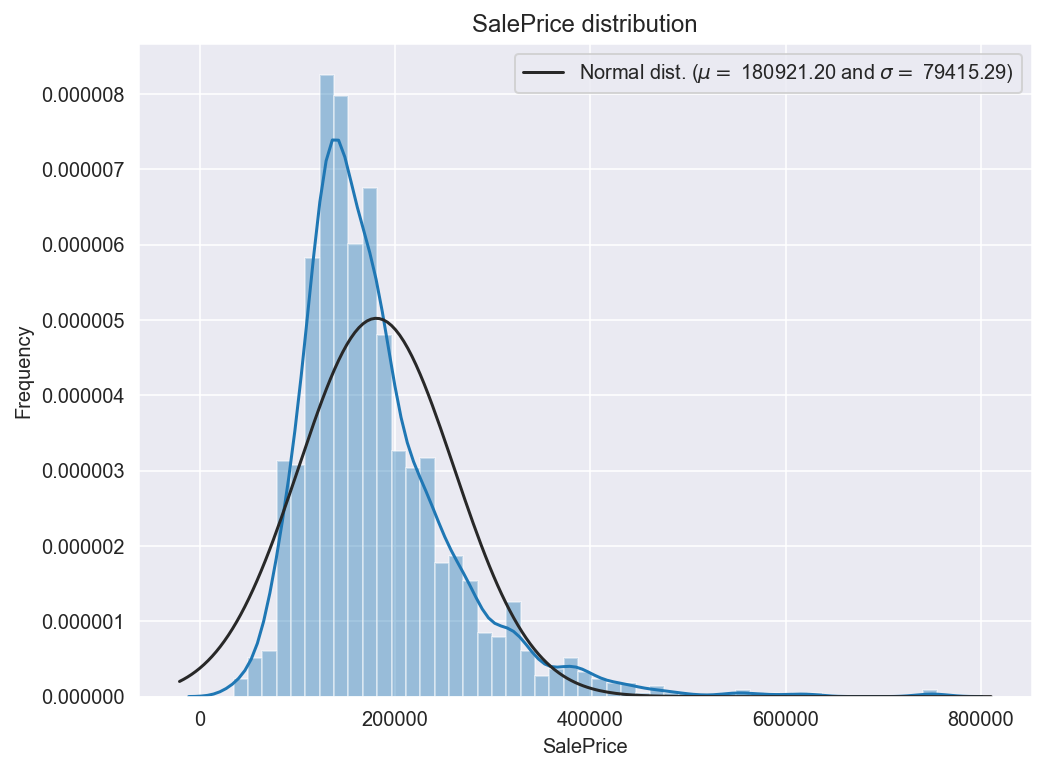

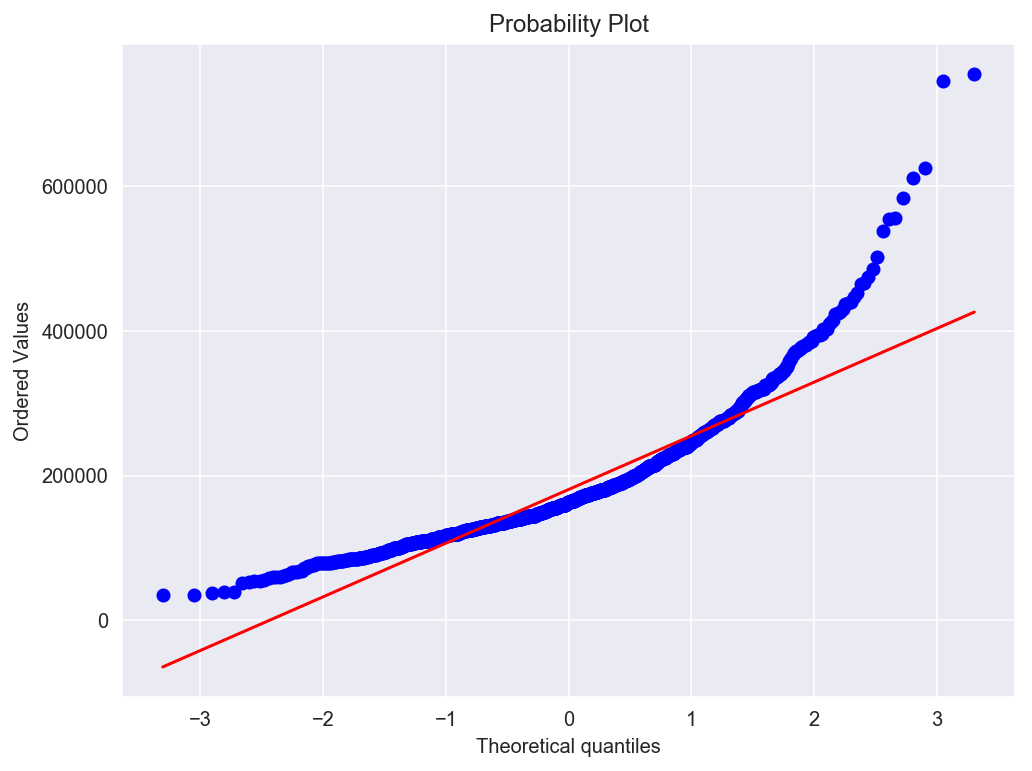

In [69]:
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
normal_distribution_plot('SalePrice')
# findings: target var does not follow normal distribution
# rather it has high positive skewness and peakedness

In [71]:
train["SalePrice"].describe() 
# findings: no strane values that have property price <= 0 

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

## 2.2 Explore Important Indepent Variables for Modelling

<Figure size 576x432 with 0 Axes>

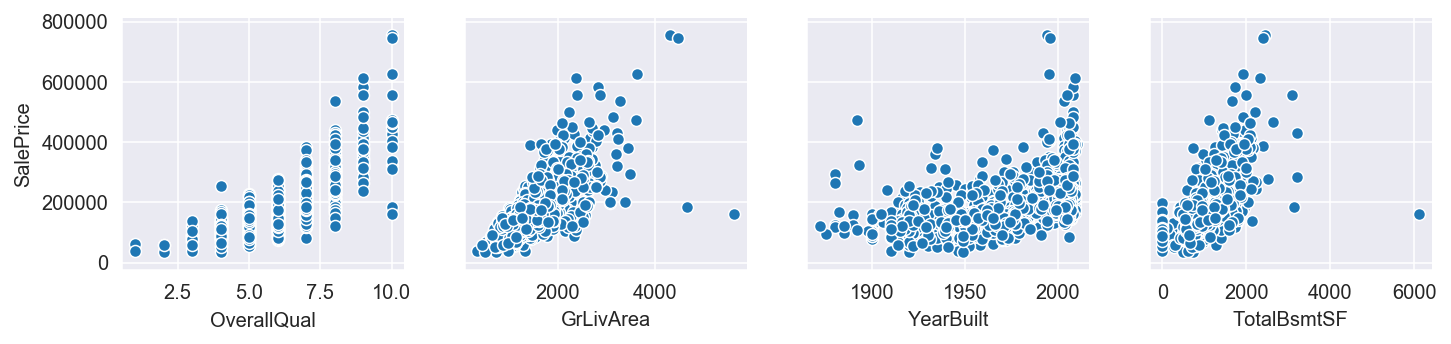

In [72]:
# draw scatter plot to find some patterns and outliers from selected important variables

figure=plt.figure()
imp_vars = ['OverallQual','GrLivArea', 'YearBuilt','TotalBsmtSF']
sns.pairplot(x_vars=imp_vars, y_vars=['SalePrice'], data=train, dropna=True)
plt.show()
# findings: OverallQual is a very strong predictor
# GrLivArea has almost linear relationship with the target var, two outliers appear in the right hand side part of the figure
# YearBuilt: from around 70's onwardsm newly-built houses/apartments have higher price
# TotalBsmtSF: lots of properties have no basement (TotalBsmtSF=0) on the left side of the figure, some outliers appeared

In [74]:
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index,inplace=True)
train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index,inplace=True)
train.drop(train[(train['YearBuilt']<1900) & (train['SalePrice']>400000)].index,inplace=True)
train.drop(train[(train['TotalBsmtSF']>6000) & (train['SalePrice']<200000)].index,inplace=True)
train.reset_index(drop=True, inplace=True)
train.shape

(1456, 81)

## 2.3 Understand Independent Variables

In [80]:
# concat data
all_data = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                     test.loc[:, 'MSSubClass':'SaleCondition']))
# concat vertically
all_data.shape
all_data.reset_index(drop=True, inplace=True)

In [81]:
all_data.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2910,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2911,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2912,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2913,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
2914,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [82]:
# check what types of data we have
# count of variable types
def data_type_statistics(df=all_data):
    df_types = pd.DataFrame(df.dtypes)
    df_types.columns = ['type']
    print(df_types.type.value_counts())

data_type_statistics()
# findings: more than half (43/79) are categorical while 36 of 79 are numerical vars

object     43
int64      25
float64    11
Name: type, dtype: int64


In [83]:
df_types[df_types.type=='int64']
# findings: some vars have type of int are actually categorical, e.g. OverallCond, YearBuilt
# need to adjust their type as object later - see Feature Engineering

,type
MSSubClass,int64
LotArea,int64
OverallQual,int64
OverallCond,int64
YearBuilt,int64
YearRemodAdd,int64
1stFlrSF,int64
2ndFlrSF,int64
LowQualFinSF,int64
GrLivArea,int64


# 3. Feature Engineering

## 3.1 Numerical to Categorical

In [55]:
# as long as col has a type of string, pandas will treat it as categorical var
for col in ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']:
    all_data[col] = all_data[col].astype(str)

# check after data type modification
data_type_statistics()
# 47 vs. 43 categorical vars

object     47
int64      21
float64    11
Name: type, dtype: int64


## 3.2 Add total_sq

In [56]:
# add one derived feature
all_data['total_sq'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

## 3.3 log transform target var and plot

In [ ]:
# for the sake of liner models
# use np.log1p(x) instead of np.log(x) b/c some cols many contain 0
train["SalePrice"] = np.log1p(train["SalePrice"])
normal_distribution_plot('SalePrice')
# after transformation the target looks more normally distributed

In [41]:
train_high_var = train.loc[:,train.apply(pd.Series.nunique) != 1]
train_high_var.shape

(1460, 81)

In [43]:
all_data.std()

MSSubClass         42.517628
LotFrontage        23.344905
LotArea          7886.996359
OverallQual         1.409947
OverallCond         1.113131
YearBuilt          30.291442
YearRemodAdd       20.894344
MasVnrArea        179.334253
BsmtFinSF1        455.610826
BsmtFinSF2        169.205611
BsmtUnfSF         439.543659
TotalBsmtSF       440.766258
1stFlrSF          392.362079
2ndFlrSF          428.701456
LowQualFinSF       46.396825
GrLivArea         506.051045
BsmtFullBath        0.524736
BsmtHalfBath        0.245687
FullBath            0.552969
HalfBath            0.502872
BedroomAbvGr        0.822693
KitchenAbvGr        0.214462
TotRmsAbvGrd        1.569379
Fireplaces          0.646129
GarageYrBlt        25.574285
GarageCars          0.761624
GarageArea        215.394815
WoodDeckSF        126.526589
OpenPorchSF        67.575493
EnclosedPorch      64.244246
3SsnPorch          25.188169
ScreenPorch        56.184365
PoolArea           35.663946
MiscVal           567.402211
MoSold        

In [45]:
train.Utilities.describe()

count       1460
unique         2
top       AllPub
freq        1459
Name: Utilities, dtype: object